# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Оглавление:
1. [Откройте файл с данными и изучите общую информацию](#Общая-информация)
2. [Предобработка данных](#Предобработка-данных)
3. [Посчитайте и добавьте в таблицу новые столбцы](#Посчитайте-и-добавьте-в-таблицу-новые-столбцы)
4. [Проведите исследовательский анализ данных](#Проведите-исследовательский-анализ-данных)
5. [Общий вывод](#Общий-вывод)

### Общая информация. 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


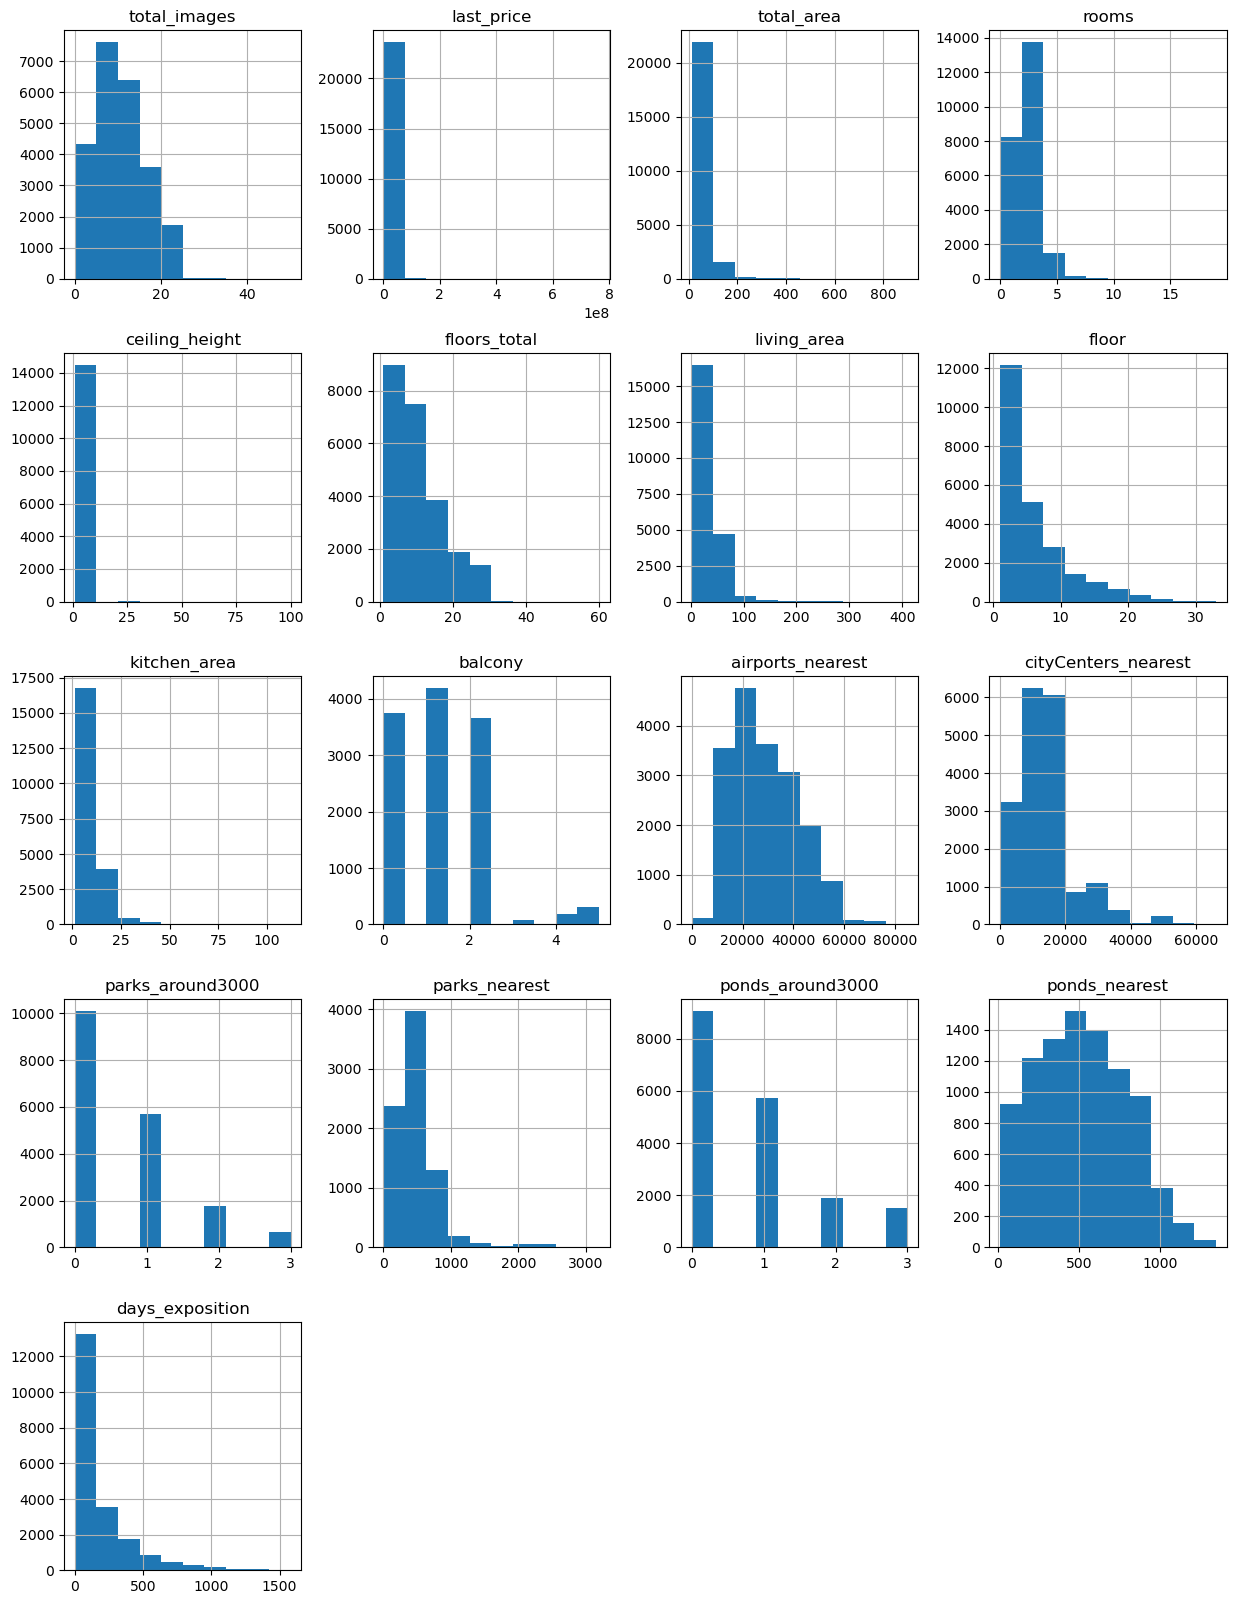

In [17]:
df.hist(figsize=(15, 20))
plt.show()

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Предобработка данных

[Вернуться к оглавлению](#Оглавление:)

#### **Посчитаю количество пропусков.**

In [19]:
for i in df.columns:
    if df[i].isna().sum() != 0:
        print(f'количество пропусков в {i}: {df[i].isna().sum()}')

количество пропусков в ceiling_height: 9195
количество пропусков в floors_total: 86
количество пропусков в living_area: 1903
количество пропусков в is_apartment: 20924
количество пропусков в kitchen_area: 2278
количество пропусков в balcony: 11519
количество пропусков в locality_name: 49
количество пропусков в airports_nearest: 5542
количество пропусков в cityCenters_nearest: 5519
количество пропусков в parks_around3000: 5518
количество пропусков в parks_nearest: 15620
количество пропусков в ponds_around3000: 5518
количество пропусков в ponds_nearest: 14589
количество пропусков в days_exposition: 3181


#### Изменю тип данных и заполню пропуски там, где есть такая возможность.

In [27]:
# Должен быть тип данных datetime.
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

# В столбце с высотой потолка есть пропущенные значения, их я заполнил медианой.
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

# Пропуски заменю на медиану — даже если выбор не удачный, этих значений слишком мало, чтобы исказить общую картину. 
# Должен быть тип данных int.
df['floors_total'] = df['floors_total'].fillna(df['floors_total'].median()).astype('int')

# Должен быть тип данных int.
# Пропуски в тех местах, где нет балкона.
df['balcony'] = df['balcony'].fillna(0).astype('int')

# Должен быть тип данных int.
# Вероятнее всего, пропуски говорят нам об отсутствии водоемов вблизи.
# Эту догадку подтверждает, что точно такие же значения имеет столбец parks_around3000
df['ponds_around3000'] = df['ponds_around3000'].fillna(0).astype('int')
df['parks_around3000'] = df['parks_around3000'].fillna(0).astype('int')

# Заменил тип данных на int, чтобы избавиться от копеек.
df['last_price'] = df['last_price'].astype('int')

**Оставшиеся пропуски, изучу их поближей.**

In [21]:
for i in df.columns:
    if df[i].isna().sum() != 0:
        print(f'количество пропусков в {i}: {df[i].isna().sum()}')

количество пропусков в living_area: 1903
количество пропусков в is_apartment: 20924
количество пропусков в kitchen_area: 2278
количество пропусков в locality_name: 49
количество пропусков в airports_nearest: 5542
количество пропусков в cityCenters_nearest: 5519
количество пропусков в parks_nearest: 15620
количество пропусков в ponds_nearest: 14589
количество пропусков в days_exposition: 3181


In [28]:
df.query('living_area.isna() and kitchen_area.isna()').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000,159.0,2015-07-24,3,2.65,14,NaN,9,NaN,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
30,12,2200000,32.8,2018-02-19,1,2.65,9,NaN,2,NaN,...,NaN,0,Коммунар,NaN,NaN,0,NaN,0,NaN,63.0
37,10,1990000,45.8,2017-10-28,2,2.50,5,NaN,1,NaN,...,NaN,0,поселок городского типа Красный Бор,NaN,NaN,0,NaN,0,NaN,196.0
44,13,5350000,40.0,2018-11-18,1,2.65,22,NaN,3,NaN,...,NaN,1,Санкт-Петербург,30471.0,11603.0,1,620.0,1,1152.0,NaN
59,15,6300000,46.5,2017-03-06,1,2.65,13,NaN,13,NaN,...,NaN,0,Санкт-Петербург,11125.0,14501.0,0,NaN,0,NaN,336.0


**Стоит обратить внимание, что в столбцах living_area, is_apartment, kitchen_area и floors_total пропуски идут вместе . Можно предположить, что это либо здания, не предназначенные для жилья, либо недостроенные здания. В любом случае, эти пропуски придется оставить как есть, я с ними ничего не могу сделать. Исключение — floors_total, пропусков всего 86, я заменил их на медиану, так как они не смогут повлиять на общий вид.**

In [31]:
df.query('parks_nearest.isna() and ponds_nearest.isna()').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.60,1,NaN,...,11.00,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.40,5,NaN,...,9.10,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.60,6,NaN,...,14.40,1,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0
7,5,7915000,71.60,2019-04-18,2,2.65,24,NaN,22,NaN,...,18.90,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.43,26,NaN,...,8.81,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,189.0


**Пропуски значений parks_nearest и ponds_nearest идут рядом. Пропуски указывают на то, что рядом с жильем нет ни того, ни другого. Я бы рекомендовал разработчикам сайта изменить эту графу на что-то более информативное, чтобы об отсутсвии парка/водоема говорил не пропуск.**

In [32]:
df.query('cityCenters_nearest.isna() and airports_nearest.isna()').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.40,5,NaN,...,9.10,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.43,26,NaN,...,8.81,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,189.0
12,10,3890000,54.00,2016-06-30,2,2.65,5,30.00,5,NaN,...,9.00,0,Сертолово,NaN,NaN,0,NaN,0,NaN,90.0
22,20,5000000,58.00,2017-04-24,2,2.75,25,30.00,15,NaN,...,11.00,2,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,60.0
30,12,2200000,32.80,2018-02-19,1,2.65,9,NaN,2,NaN,...,NaN,0,Коммунар,NaN,NaN,0,NaN,0,NaN,63.0


In [33]:
df.query('cityCenters_nearest.isna() and airports_nearest.isna() and locality_name=="Санкт-Петербург" ').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
81,9,10949000,68.0,2018-12-27,1,2.65,10,NaN,6,NaN,...,NaN,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN
593,20,4200000,38.3,2019-04-16,1,2.60,16,19.8,10,NaN,...,10.1,2,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN
604,11,9899000,101.0,2018-12-12,3,3.00,5,62.0,3,NaN,...,15.0,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN
742,7,37000000,161.0,2016-05-22,3,2.65,9,84.0,8,NaN,...,NaN,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,402.0
795,19,7100000,59.6,2019-02-13,2,3.40,5,36.6,2,NaN,...,12.5,0,Санкт-Петербург,NaN,NaN,0,NaN,0,NaN,NaN


**Сначала я хотел предположить, что пропуски в airports_nearest и cityCenters_nearest присущи населенным пунктам в области. Но по таблице видно, что такие значения есть и в Питере. В этом случай можно догадаться, что некоторые поля являются не обязательными для заполнения. После мёрджа таблиц, программа сама заполняет пропуски.**

In [34]:
df.query('days_exposition.isna()').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
7,5,7915000,71.6,2019-04-18,2,2.65,24,NaN,22,NaN,...,18.9,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN
44,13,5350000,40.0,2018-11-18,1,2.65,22,NaN,3,NaN,...,NaN,1,Санкт-Петербург,30471.0,11603.0,1,620.0,1,1152.0,NaN
45,17,5200000,50.6,2018-12-02,2,2.65,9,30.3,7,NaN,...,7.0,0,Санкт-Петербург,30011.0,12872.0,0,NaN,0,NaN,NaN
46,17,6600000,52.1,2019-01-31,2,2.60,24,29.7,9,NaN,...,8.3,2,Санкт-Петербург,15114.0,12702.0,0,NaN,0,NaN,NaN


**Я не обнаружил какой-либо зависимость у days_exposition с другими колонками. Могу предположить, что на момент формирования таблицы, эти объявления все еще были опубликованы.**

#### Найду и уберу дубликаты в названии населенных пунктов.

In [35]:
len(df['locality_name'].unique())

365

**В этом столбце много неявных дубликатов. Привожу все к единообразию.**

In [36]:
def remove_mistakes(row):
    if 'посёлок' in str(row):
        return row.replace('посёлок', 'поселок')
    return row

df['locality_name'] = df['locality_name'].apply(remove_mistakes)

df['locality_name'] = df['locality_name'].replace(['деревня Мурино', 'поселок Мурино'], 'Мурино')
df['locality_name'] = df['locality_name'].replace('деревня Кудрово', 'Кудрово')
# Теперь остались только пропущенные значения, с которыми я ничего не могу сделать.
len(df['locality_name'].unique())

329

In [37]:
df['locality_name'].value_counts()

Санкт-Петербург         15721
Мурино                    590
Кудрово                   472
поселок Шушары            440
Всеволожск                398
                        ...  
деревня Курковицы           1
деревня Шпаньково           1
деревня Лаврики             1
поселок Тёсово-4            1
поселок Дзержинского        1
Name: locality_name, Length: 328, dtype: int64

**Больше половины объявлений о продаже жилья в Санкт-Петербурге и его пригородах — Мурино и Кудрово.**

#### Уберу подозрительные значения.

**В этом столбце есть низкая цена.**

In [38]:
df['last_price'].min()

12190

In [39]:
df['last_price'] = df['last_price'].replace(12190.0, df['last_price'].median())

**Домов без комнат не бывает.**

In [40]:
df['rooms'].min()

0

In [41]:
df['rooms'] = df['rooms'].replace(0, 1)

**Потолки высотой от 1 до 100 метров? Надо разобраться.**

In [42]:
df['ceiling_height'].min()

1.0

In [43]:
df['ceiling_height'].max()

100.0

In [44]:
for i in df['ceiling_height']:
    if i >= 14:
        df['ceiling_height'] = df['ceiling_height'].replace(i, i // 10)
    elif i < 1.5:
        df['ceiling_height'] = df['ceiling_height'].replace(i, i + 1)

In [45]:
df['ceiling_height'].max()

10.3

**Многовато, но оставлю. При рассчетах подрежу эти выбросы.**

### Посчитайте и добавьте в таблицу новые столбцы

[Вернуться к оглавлению](#Оглавление:)

**Цена за кв. метр.**

In [46]:
df['price_per_sqre_meter'] = df['last_price'] / df['total_area']

**Добавляю колонки с днем/месяц/годом размещения объявления.**

In [47]:
df['weekday'] = pd.DatetimeIndex(df['first_day_exposition']).weekday
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year

**Расстояние до центра и аэропорта теперь указано в километрах.**

In [48]:
df['cityCenters_nearest'] = (df['cityCenters_nearest'] / 1000).round()
df['airports_nearest'] = (df['airports_nearest'] / 1000).round()

**Сделал три категории квартир в зависимости от этажа.**

In [49]:
def type_floor(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] != 1 and row['floors_total'] == row['floor']:
        return 'последний'
    else:
        return 'другой'
        
df['type_of_floor'] = df.apply(type_floor, axis=1)
df['type_of_floor'].value_counts()

другой       17441
последний     3341
первый        2917
Name: type_of_floor, dtype: int64

**Добавил категории — как долго висит объявление.**

In [50]:
def days_exposition_categories(row):
    if row <= 45:
        return 'до 45 дней'
    elif 45 < row < 232 :
        return 'от 45 до 232 дней'
    elif 232 <= row <= 510:
        return 'от 232 до 510 дней'    
    else:
        return 'больше 510 дней (выброс)'

df['days_exposition_new'] = df['days_exposition'].apply(days_exposition_categories)    

**Для удобства счета разделю значения стоимости на 1 млн.**

In [51]:
def comfortable_func(row):
    return row / 10**6

df['last_price_in_million'] = df['last_price'].apply(comfortable_func)

### Проведите исследовательский анализ данных

In [105]:
dubles = df.drop_duplicates()

if dubles.shape[0] == df.shape[0]:
    print("Нет полностью одинаковых строк")
else:
    print("Есть полностью одинаковые строки")

Нет полностью одинаковых строк


[Вернуться к оглавлению](#Оглавление:)

#### Площадь

In [52]:
df['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

<AxesSubplot:>

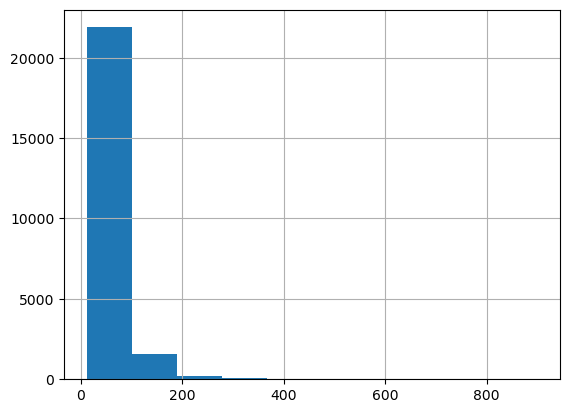

In [53]:
df['total_area'].hist()

**Выбросы не дают увидеть полную картину, от них нужно избавиться.**

<AxesSubplot:>

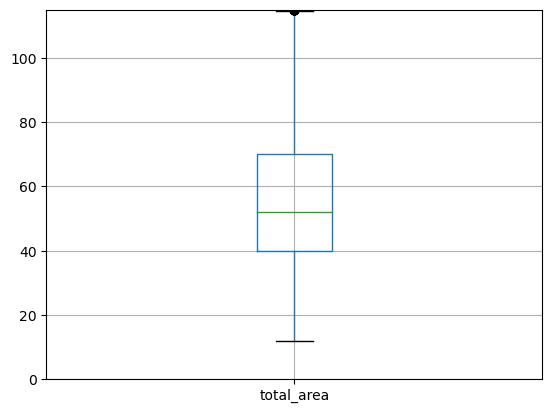

In [54]:
plt.ylim(0, 115)
df.boxplot('total_area')

**Большая часть значений находится до 75 кв.м.**

**Исходя из значений ящика с усами, площадь больше 115 кв.м. и меньше 15 кв.м. являются выбросами. Это значения за пределами третьего и первого квартилей.**

<AxesSubplot:>

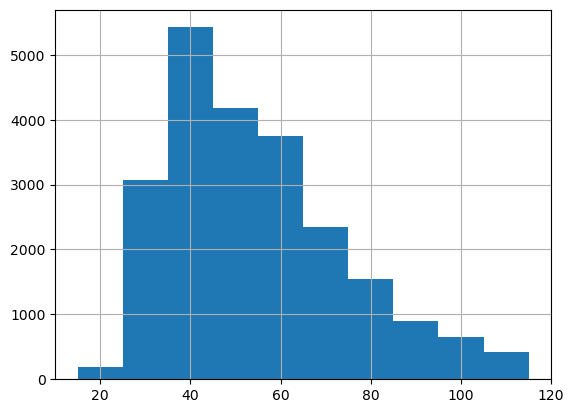

In [55]:
df['total_area'].hist(range=(15, 115))

**Получили распределение Пуассона. Большинство квартир имеют площадь от 25 до 70 квадратных метров.**

#### Жилая площадь

In [56]:
df['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

<AxesSubplot:>

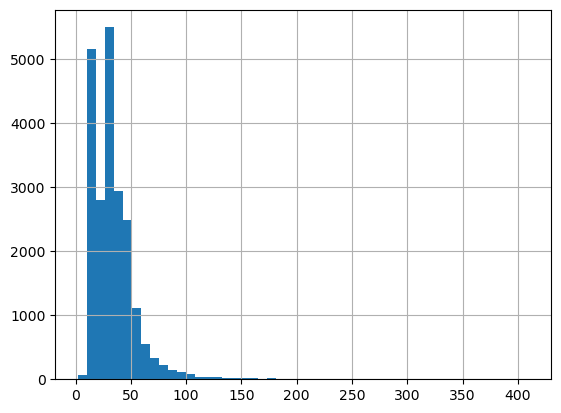

In [57]:
df['living_area'].hist(bins=50)

<AxesSubplot:>

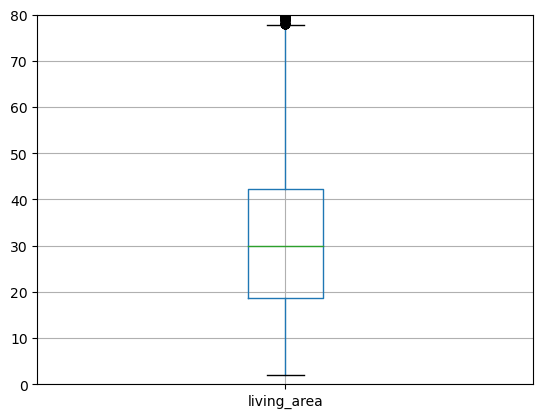

In [58]:
plt.ylim(0, 80)
df.boxplot('living_area')

**Интересующие, нормальные, значения лежат ниже 74 кв.м. Все, что выше, — выброс. Избавлюсь от них.**

<AxesSubplot:>

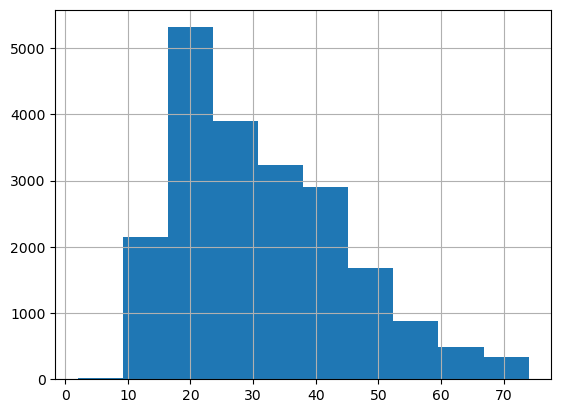

In [106]:
df['living_area'].hist(range=(2, 74))

**Распределение Пуассона. Причем график очень похож на предыдущий. Стоит проверить, насколько хорошо коррелируют между собой эти колонки.**

In [107]:
df['living_area'].corr(df['total_area'])

0.9395373338721501

**Видна сильная взаимосвязь между жилой и общей площадью, что, в общем-то, логично. Если потребуется, позже вернусь к этому значению.**

#### Площадь кухни

In [108]:
df['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

<AxesSubplot:>

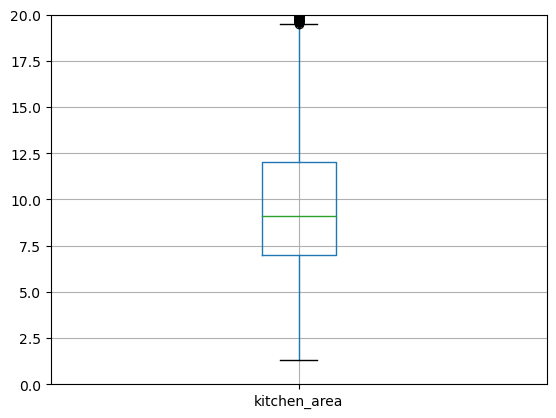

In [109]:
plt.ylim(0, 20)
df.boxplot('kitchen_area')

**Значения меньше 1.25 кв.м и больше 19 кв.м явялются выбросами.**

<AxesSubplot:>

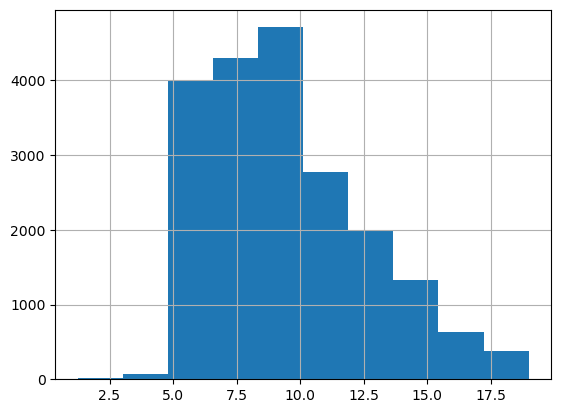

In [110]:
df['kitchen_area'].hist(range=(1.25, 19))

**Распределение Пуассона. Проверю, насколько размер кухни коррелирует с общей площадью:**

In [111]:
df['kitchen_area'].corr(df['total_area'])

0.6091211711198313

**Зависимость скорее положительная, но нельзя с уверенностью сказать, что, чем больше квартира, тем больше кухня. Бывают исключения.**

#### Цена объекта

In [112]:
df['last_price_in_million'].describe()

count    23699.000000
mean         6.541744
std         10.886938
min          0.430000
25%          3.400000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price_in_million, dtype: float64

<AxesSubplot:>

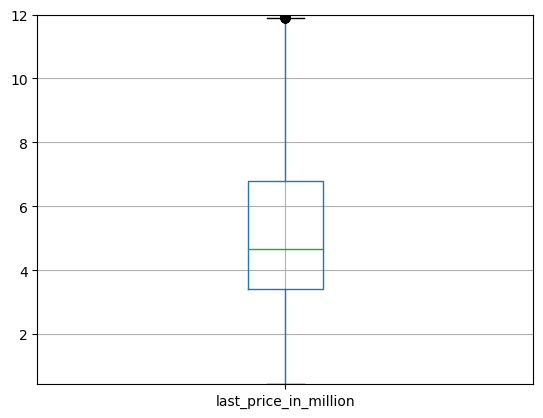

In [113]:
plt.ylim(0.43, 12)
df.boxplot('last_price_in_million')

**Выброс лежит за пределами цены 12 млн. рублей за квартиру.**

<AxesSubplot:>

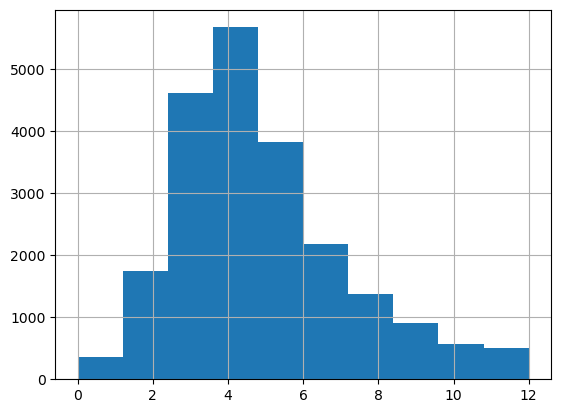

In [114]:
df['last_price_in_million'].hist(range=(0, 12))

In [115]:
df[df['last_price_in_million'] < 12000000]['last_price_in_million'].median()

4.65

**Стоимость большинства квартир лежит в между 2 млн и 7 млн, медиана — 4.65 млн.**

In [116]:
price_per_city = (
    df.pivot_table(index='locality_name',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
)
price_per_city

,last_price_in_million
locality_name,
деревня Старополье,0.450000
деревня Вахнова Кара,0.450000
деревня Чудской Бор,0.500000
поселок Совхозный,0.517500
поселок станции Свирь,0.575000
...,...
Санкт-Петербург,5.500000
поселок Репино,8.083708
поселок Александровская,8.725000


In [117]:
df[['last_price_in_million', 'locality_name']].sort_values(by='last_price_in_million')

,last_price_in_million,locality_name
17456,0.43,Сланцы
14911,0.43,поселок станции Свирь
16274,0.44,деревня Старополье
17676,0.45,деревня Ям-Тесово
9581,0.45,деревня Старополье
...,...,...
15651,300.00,Санкт-Петербург
1436,330.00,Санкт-Петербург
14706,401.30,Санкт-Петербург
19540,420.00,Санкт-Петербург


**На цену жилья влияет населенный пункт. Поисковик подсказывает, что, например, деревня Хязельки — это элитный коттеджный поселок рядом с СПб, деревня Старополье — находится далеко от СПб, поэтому цена соответствующая.**

#### Количество комнат

In [118]:
df['rooms'].describe()

count    23699.000000
mean         2.078948
std          1.066196
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

<AxesSubplot:>

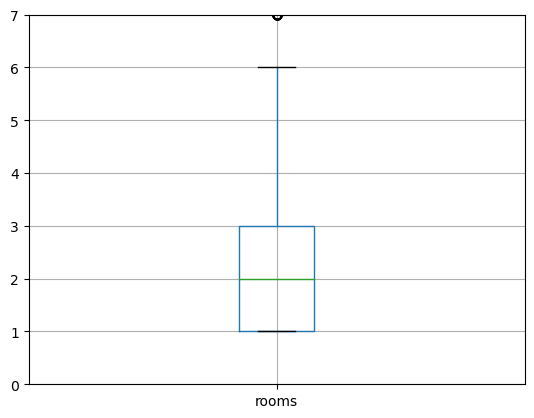

In [119]:
plt.ylim(0, 7)
df.boxplot('rooms')

<AxesSubplot:>

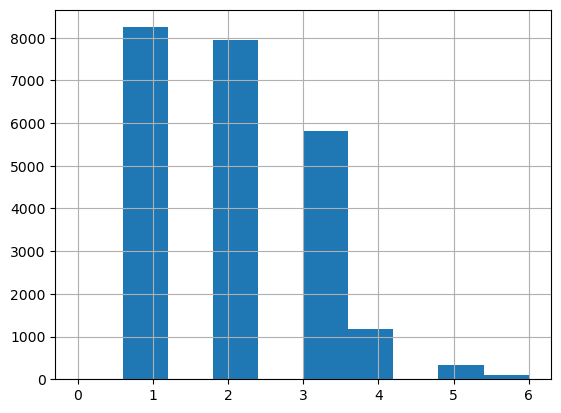

In [120]:
df['rooms'].hist(range=(0, 6))

**В большинстве объявлений представлено с 1-3 комнатами. Жилье с более чем 6 комнатами — выброс.**

#### Высота потолков

In [121]:
df['ceiling_height'].describe()

count    23699.000000
mean         2.697813
std          0.242720
min          1.750000
25%          2.600000
50%          2.650000
75%          2.700000
max         10.300000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

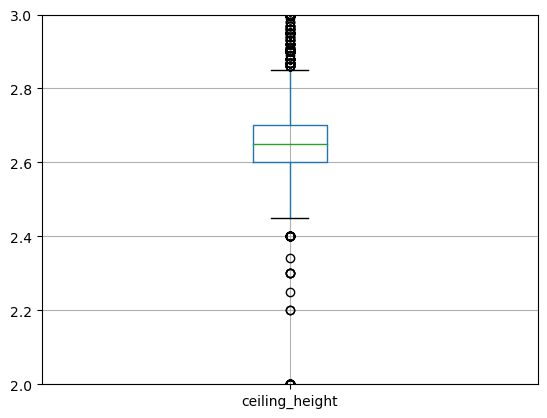

In [122]:
plt.ylim(2, 3)
df.boxplot('ceiling_height')

<AxesSubplot:>

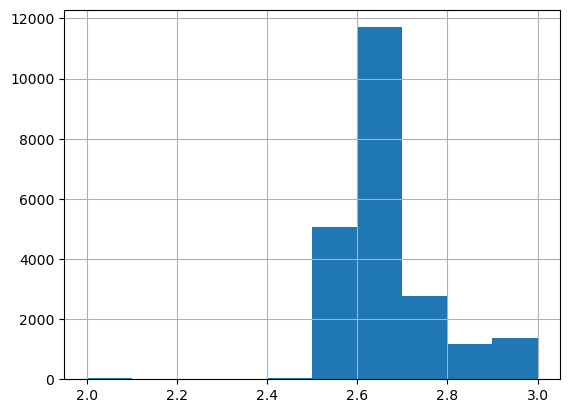

In [123]:
df['ceiling_height'].hist(range=(2, 3))

**Потолки нижей 2.5 и выше 2.85 — скорее исключение из правил. Я не стал заменять высоту потолка в 10.3 метра и около того. Это не явный выброс. Я не знаю, для чего предназначено здание, планируется ли там ремонт.**

In [124]:
df.query('2.5 < ceiling_height < 2.85')['ceiling_height'].corr(df['last_price_in_million'])

0.08093658894123802

In [125]:
df.query('2.3 < ceiling_height')['ceiling_height'].corr(df['last_price_in_million'])

0.2686790692774131

In [126]:
df.query('2.4 < ceiling_height < 2.85')['ceiling_height'].corr(df['total_area'])

0.15731463556061398

**Я ожидал увидеть более сильную взаимосвязь высоты потолков со стоимостью и площадью. Могу предположить, что высокие потолки могут иметь недостроенные здания, либо здания, не предназначенные для жилья. От этого происходит такое ценообразование.**

#### Этаж квартиры

In [127]:
df['floor'].describe()

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

<AxesSubplot:>

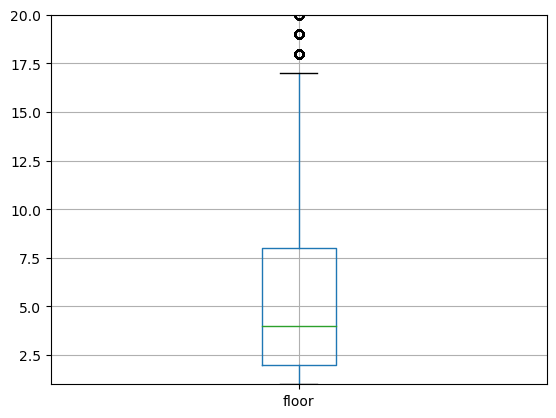

In [128]:
plt.ylim(1, 20)
df.boxplot('floor')

<AxesSubplot:>

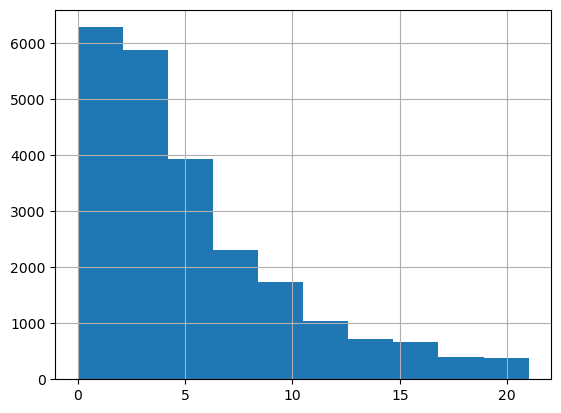

In [129]:
df['floor'].hist(range=(0, 21))

**На сайте больше всего объявлений с жильем на 0-17 этажах. Это также связано с тем, что высоких зданий меньшем. Тем более в Питере.**

#### Тип этажа квартиры («первый», «последний», «другой»)

In [130]:
df['type_of_floor'].describe()

count      23699
unique         3
top       другой
freq       17441
Name: type_of_floor, dtype: object

<AxesSubplot:>

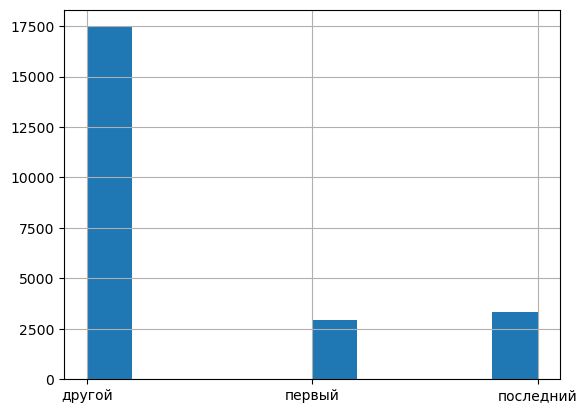

In [131]:
df['type_of_floor'].hist()

**Стоит ли отмечать то, что жилья не на крайних этажах больше всего?**

<AxesSubplot:xlabel='type_of_floor'>

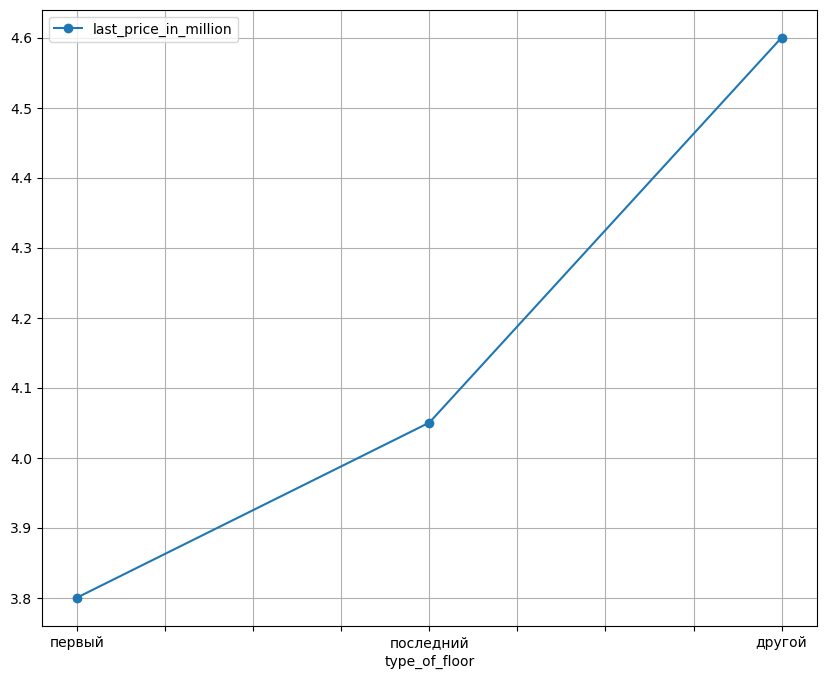

In [132]:
price_per_floor = (
    df.query('last_price_in_million < 12')
    .pivot_table(index='type_of_floor',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o-', grid=True,figsize=(10, 8))
)
price_per_floor

**Самые низки цены на жилье на первом этаже, но нужно учитывать, что в этот показатель замешались коттеджи, находящиеся в деревнях. На такие дома цены ниже.**

**Самая высокая цена на "не крайних этажах".**

#### Общее количество этажей в доме

In [133]:
df['floors_total'].describe()

count    23699.000000
mean        10.667750
std          6.585961
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<AxesSubplot:>

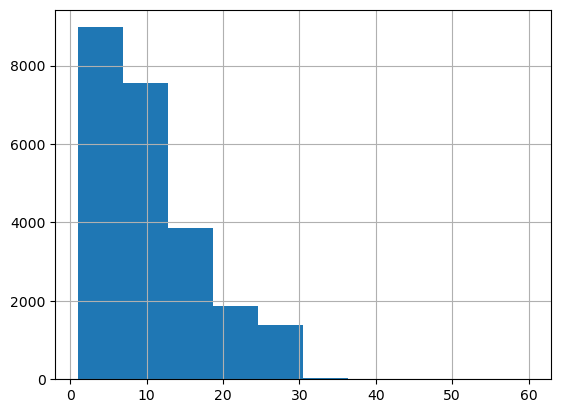

In [134]:
df['floors_total'].hist()

<AxesSubplot:>

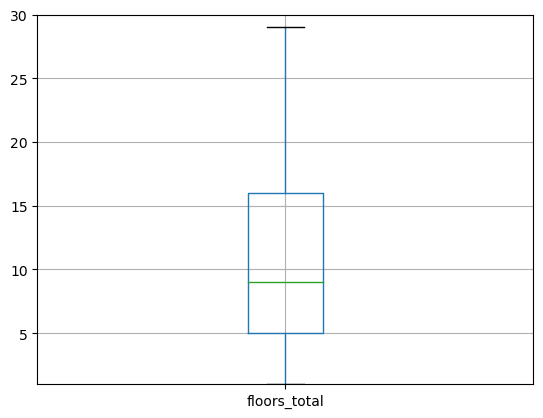

In [135]:
plt.ylim(1, 30)
df.boxplot('floors_total')

<AxesSubplot:xlabel='floors_total'>

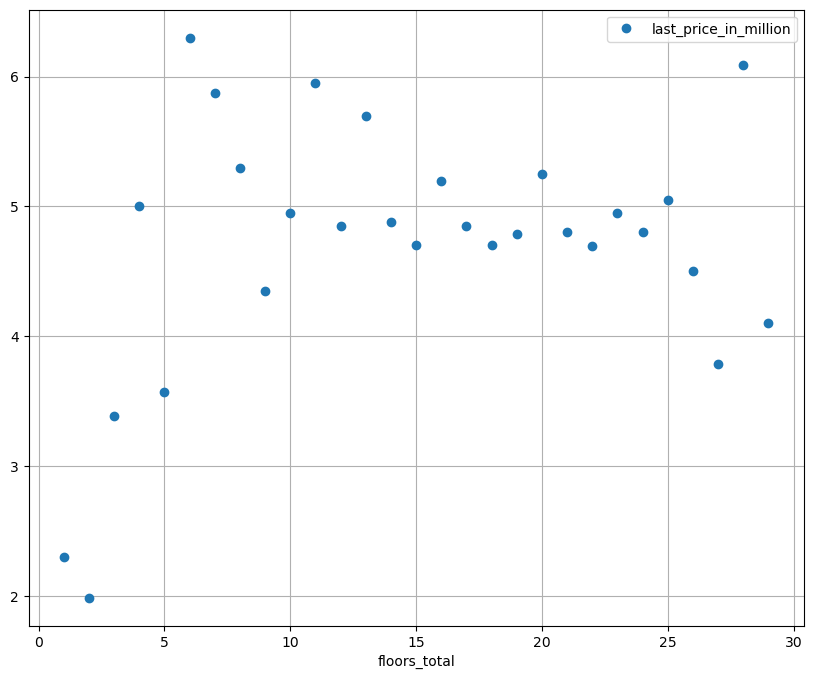

In [136]:
price_per_floor2 = (
    df.query('last_price_in_million < 12 and floors_total < 30')
    .pivot_table(index='floors_total',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True, figsize=(10, 8))
)
price_per_floor2

In [137]:
df['floors_total'].corr(df['last_price_in_million'])

-0.006963488455507071

**Больше всего объявлений с высотой здания до 10 этажей — это и старый фонд, и Лен. область. Корреляция между стоимостью и высотой совсем не существенна. По графику видно, что здания от 5 до 30 этажа имею примерно одинаковую стоимость и находятся в пределах межквартильного размаха.**

#### Расстояние до центра города в метрах

In [138]:
df['cityCenters_nearest'].describe()

count    18180.000000
mean        14.184818
std          8.616194
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: cityCenters_nearest, dtype: float64

<AxesSubplot:>

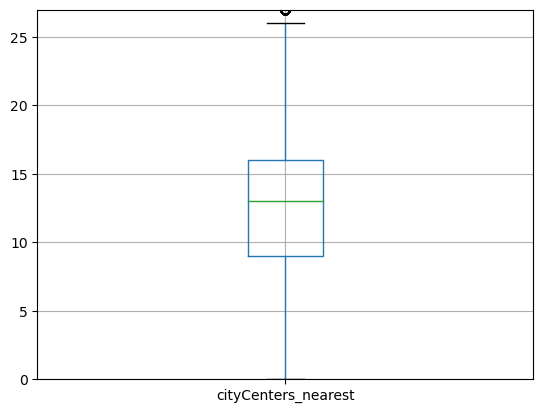

In [139]:
plt.ylim(0, 27)
df.boxplot('cityCenters_nearest')

<AxesSubplot:>

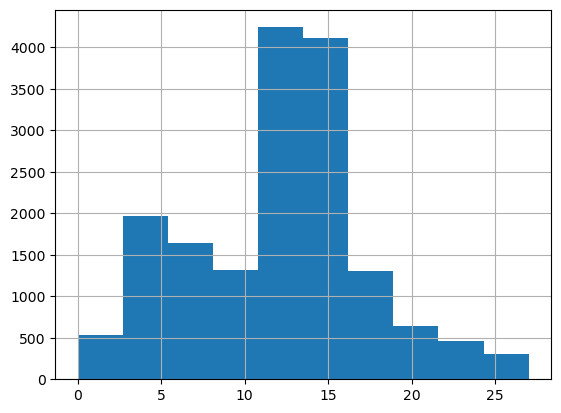

In [140]:
df['cityCenters_nearest'].hist(range=(0, 27))

**Больше половины объявлений со зданием в городелах СПб.**

<AxesSubplot:xlabel='cityCenters_nearest'>

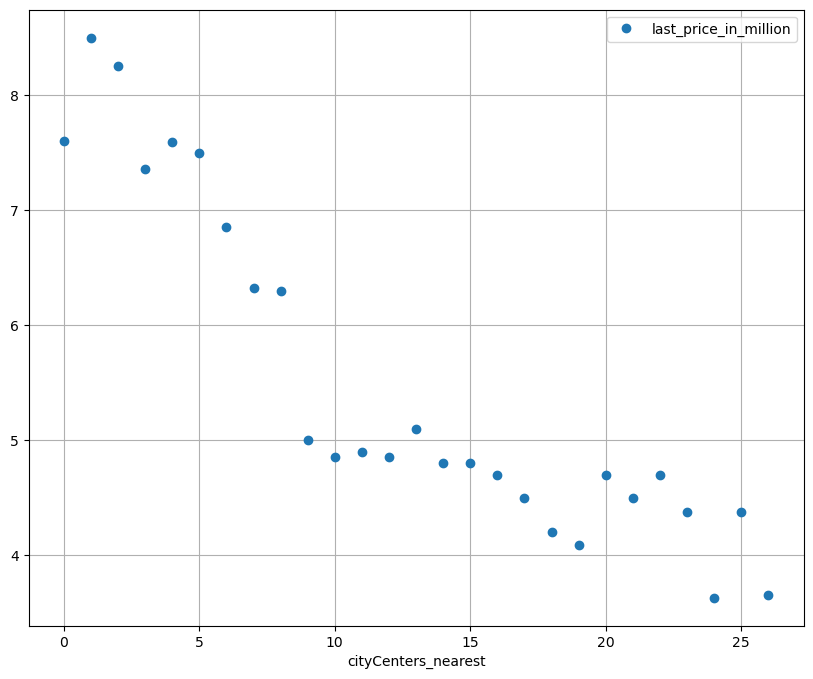

In [141]:
price_per_range = (
    df.query('last_price_in_million < 12 and cityCenters_nearest < 27')
    .pivot_table(index='cityCenters_nearest',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True, figsize=(10, 8))
)
price_per_range

In [142]:
df['cityCenters_nearest'].corr(df['last_price_in_million'])

-0.2070097682545071

**Есть отрицательная зависимость — чем дальше от центра, тем дешевле жилье. Подробнее рассмотрю эти значения ниже.**

#### Расстояние до ближайшего аэропорта

In [143]:
df['airports_nearest'].describe()

count    18157.000000
mean        28.799581
std         12.633503
min          0.000000
25%         19.000000
50%         27.000000
75%         37.000000
max         85.000000
Name: airports_nearest, dtype: float64

<AxesSubplot:>

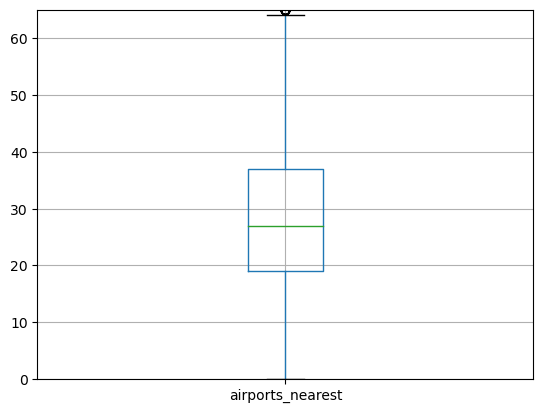

In [144]:
plt.ylim(0, 65)
df.boxplot('airports_nearest')

<AxesSubplot:>

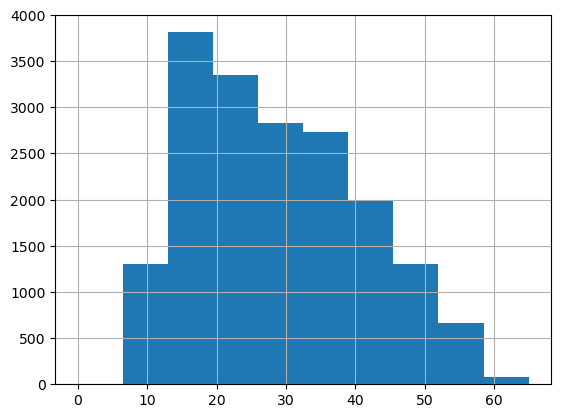

In [145]:
df['airports_nearest'].hist(range=(0, 65))

**В большинстве объявлений жилье, которое находится далеко от аэропорта**

<AxesSubplot:xlabel='airports_nearest'>

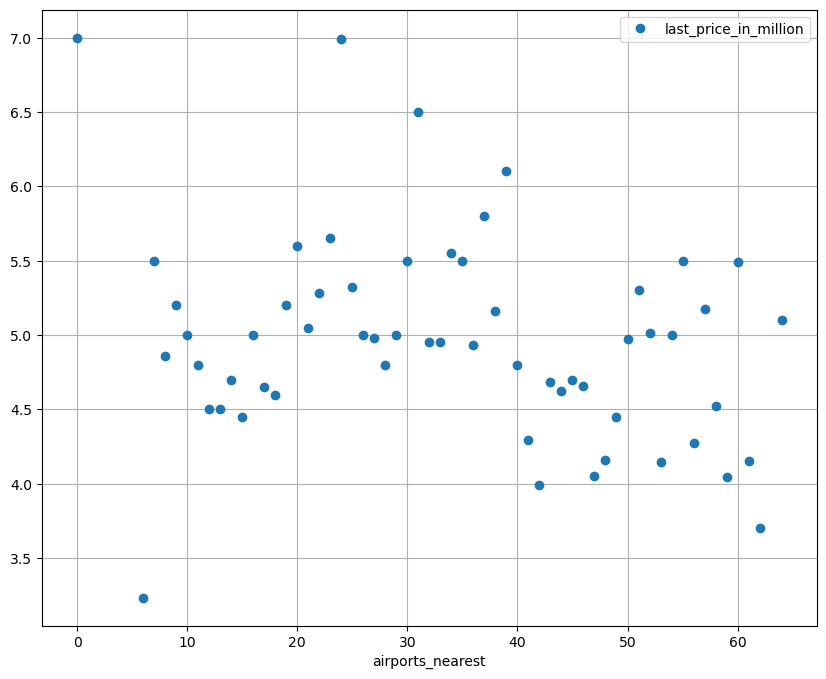

In [146]:
price_per_range_airport = (
    df.query('last_price_in_million < 12 and airports_nearest < 65')
    .pivot_table(index='airports_nearest',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True, figsize=(10, 8))
)
price_per_range_airport

In [147]:
df['airports_nearest'].corr(df['last_price_in_million'])

-0.026460557502069163

**Взаимосвязь с ценой слабая и отрицательная. Наблюдается тендеция к снижению цены по мере отдаления от аэропорту.**

#### Расстояние до ближайшего парка

In [148]:
df['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

<AxesSubplot:>

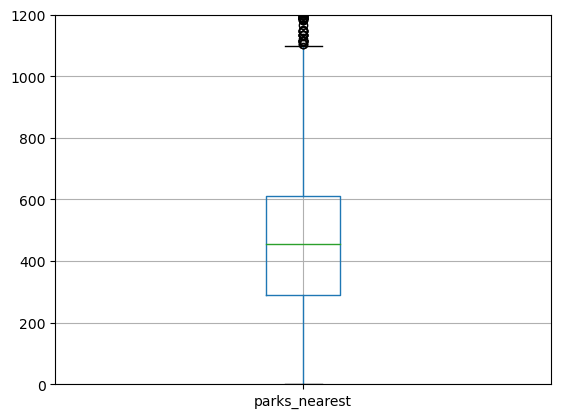

In [149]:
plt.ylim(0, 1200)
df.boxplot('parks_nearest')

<AxesSubplot:>

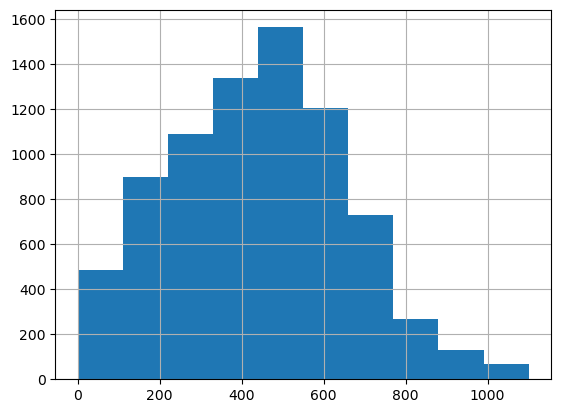

In [150]:
df['parks_nearest'].hist(range=(0, 1100))

**Большинство объявлений о продаже рядом с парками.**

In [151]:
df['parks_nearest'].corr(df['last_price_in_million'])

-0.01637998552213666

**Взаимосвязи с ценой практически нет.**

#### День и месяц публикации объявления

<AxesSubplot:>

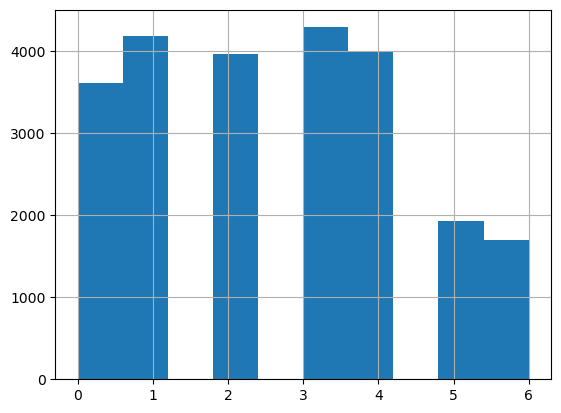

In [152]:
df['weekday'].hist()

In [153]:
df['weekday'].describe()

count    23699.000000
mean         2.569307
std          1.789082
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday, dtype: float64

**75% объявлений разместили в будние дни.**

<AxesSubplot:>

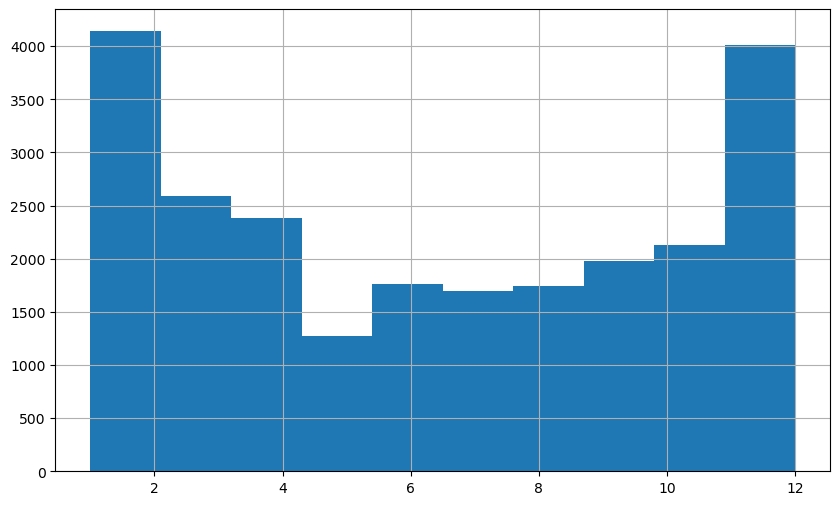

In [154]:
df['month'].hist(figsize=(10, 6))

**Количество размещенных объявлений зимой в два раза больше, чем летом.**

<AxesSubplot:xlabel='month'>

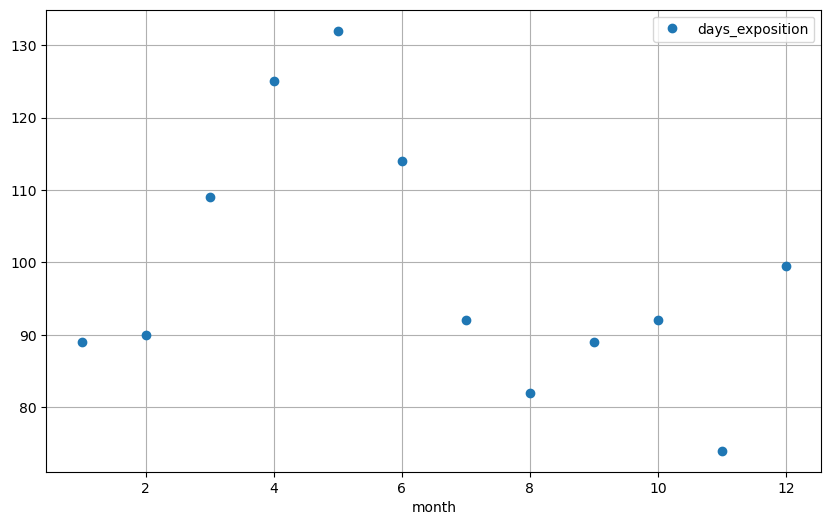

In [155]:
price_per_month = (
    df
    .pivot_table(index='month',
                   values='days_exposition',
                   aggfunc=('median')).sort_values(by='days_exposition')
    .plot(style='o', grid=True,figsize=(10, 6))
)
price_per_month

**Но продажи весной-летом выше, чем зимой**

<AxesSubplot:xlabel='month'>

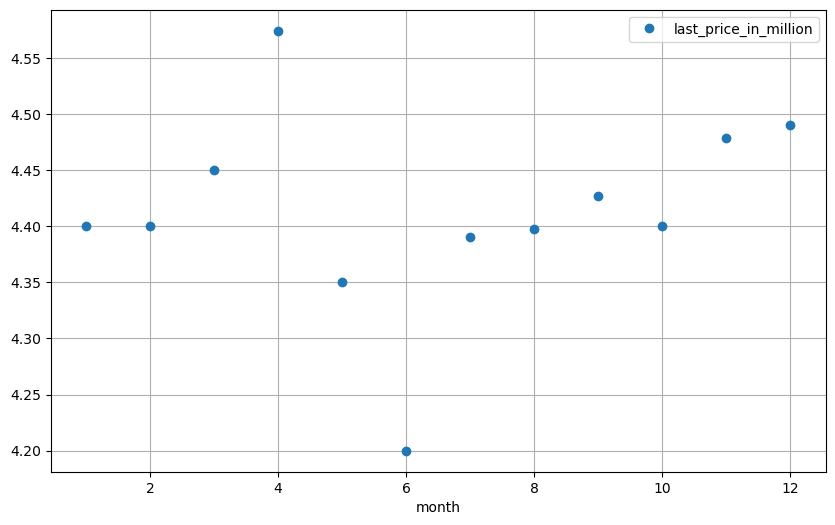

In [156]:
purchase_per_month = (
    df.query('last_price_in_million < 12')
    .pivot_table(index='month',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True,figsize=(10, 6))
)
purchase_per_month

**Цена растет пропорционально с увеличением количества объявлений!**

#### Как быстро продавались квартиры

In [157]:
df['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

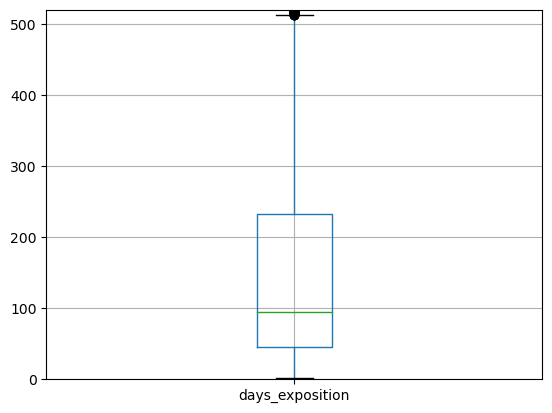

In [158]:
plt.ylim(0, 520)
df.boxplot('days_exposition')

<AxesSubplot:ylabel='days_exposition_new'>

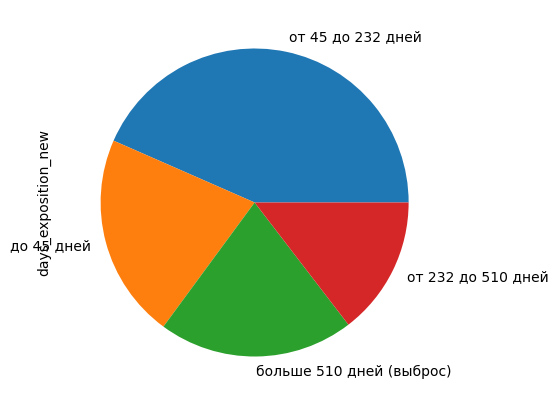

In [159]:
df['days_exposition_new'].value_counts().plot.pie(figsize=(5, 5))

**Большая часть объявлений снимают в промежуток от 45 до 232 дней. Значительная часть, почти 25% выборки, продаются очень быстро — до 45 дней.**

In [160]:
df.corr()['days_exposition']

total_images            -0.026657
last_price               0.081130
total_area               0.149675
rooms                    0.125752
ceiling_height           0.100087
floors_total            -0.052123
living_area              0.142454
floor                   -0.039463
studio                  -0.022476
open_plan               -0.024112
kitchen_area             0.100586
balcony                 -0.027834
airports_nearest        -0.018242
cityCenters_nearest     -0.060686
parks_around3000         0.055867
parks_nearest            0.023254
ponds_around3000         0.066289
ponds_nearest           -0.077879
days_exposition          1.000000
price_per_sqre_meter     0.048089
weekday                 -0.024514
month                   -0.030049
year                    -0.611308
last_price_in_million    0.081130
Name: days_exposition, dtype: float64

In [161]:
df[['days_exposition', 'year']]

,days_exposition,year
0,NaN,2019
1,81.0,2018
2,558.0,2015
3,424.0,2015
4,121.0,2018
...,...,...
23694,NaN,2017
23695,45.0,2018
23696,NaN,2018
23697,602.0,2017


**Есть слабая отрицательная корреляция с некоторыми показателями — total_images, floors_total, cityCenters_nearest и т.д. То есть какой-то отдельный параметр сам по себе не повлият на скорость продажи, важна совокупность.**

**На основе этих данных можно составить "портрет" быстрого объявления — побольше фото дома на сайте, этаж желательно не первый, свободная планировка, побольше фонтатов и всего такого прочего. Цена, разумеется, пониже.**

**Отмечу, что самый высокий показатель корреляции с годом размещения объявления — чем меньше год, тем дольше объявление висит. Что вполне логично, не думаю, что на этом стоит заострять внимание.**

#### Какие факторы больше всего влияют на общую стоимость объекта.

##### Общая площадь.

<AxesSubplot:xlabel='total_area'>

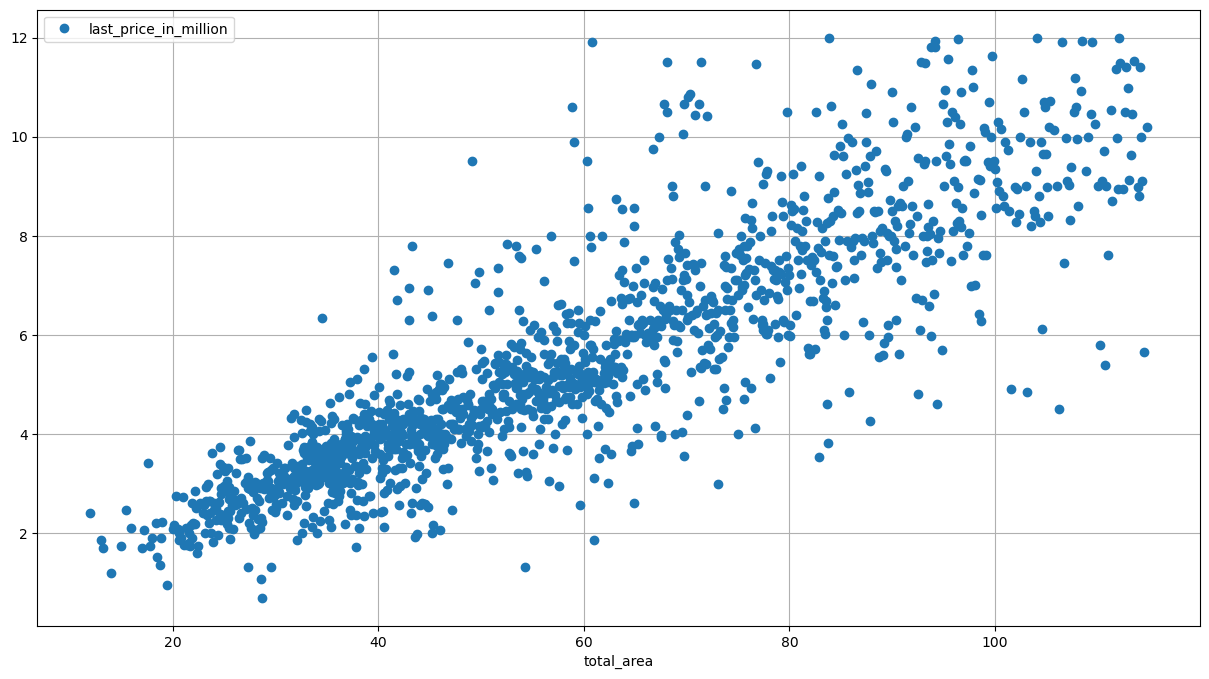

In [162]:
price_per_sqrt = (
    df.query('last_price_in_million < 12 and total_area < 115')
    .pivot_table(index='total_area',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True,figsize=(15, 8))
)
price_per_sqrt

In [163]:
df.query('total_area < 115')['total_area'].corr(df.query('last_price_in_million < 12')['last_price_in_million'])

0.6981038664979151

**Стоимость жилья хорошо коррелирует с общей площадью. Чем больше площадь — тем выше стоимость.**

##### Жилая площадь.

<AxesSubplot:xlabel='living_area'>

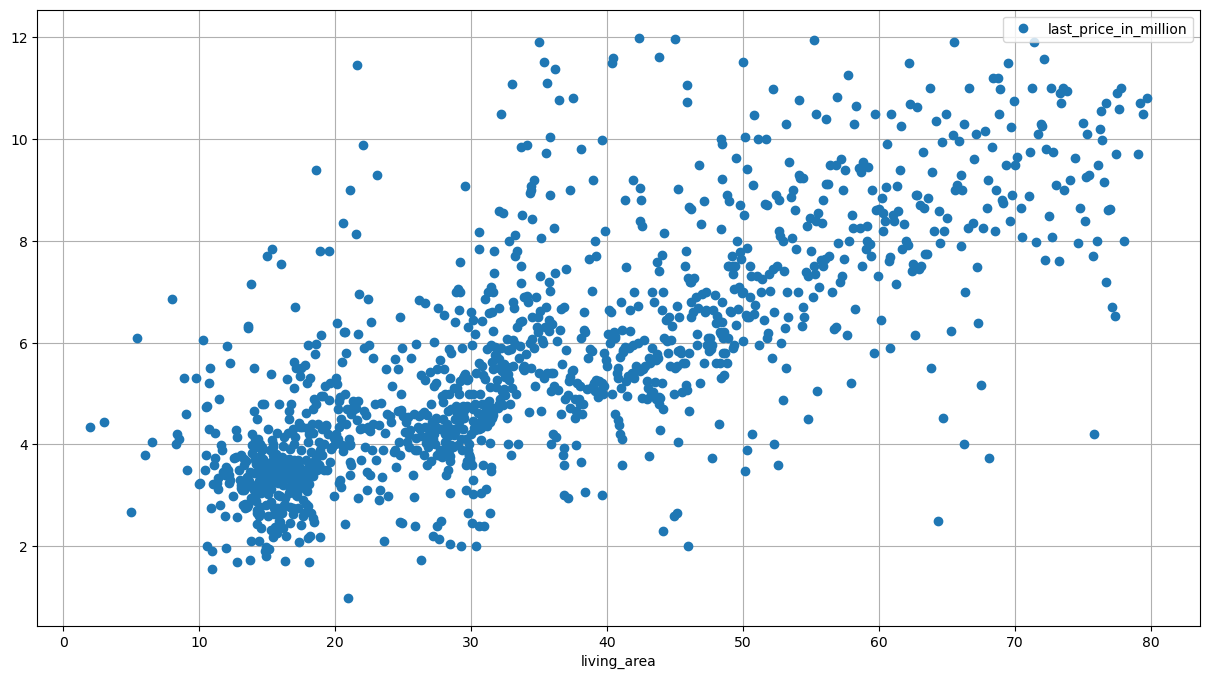

In [164]:
price_per_sqrt = (
    df.query('last_price_in_million < 12 and living_area < 80')
    .pivot_table(index='living_area',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True,figsize=(15, 8))
)
price_per_sqrt

In [165]:
df.query('living_area < 80')['living_area'].corr(df.query('last_price_in_million < 12')['last_price_in_million'])

0.575935846824392

**Также видна тенденция роста цен с увеличением жилой площади, корреляция меньше, чем в предыдущем случае.**

##### Площадь кухни.

<AxesSubplot:xlabel='kitchen_area'>

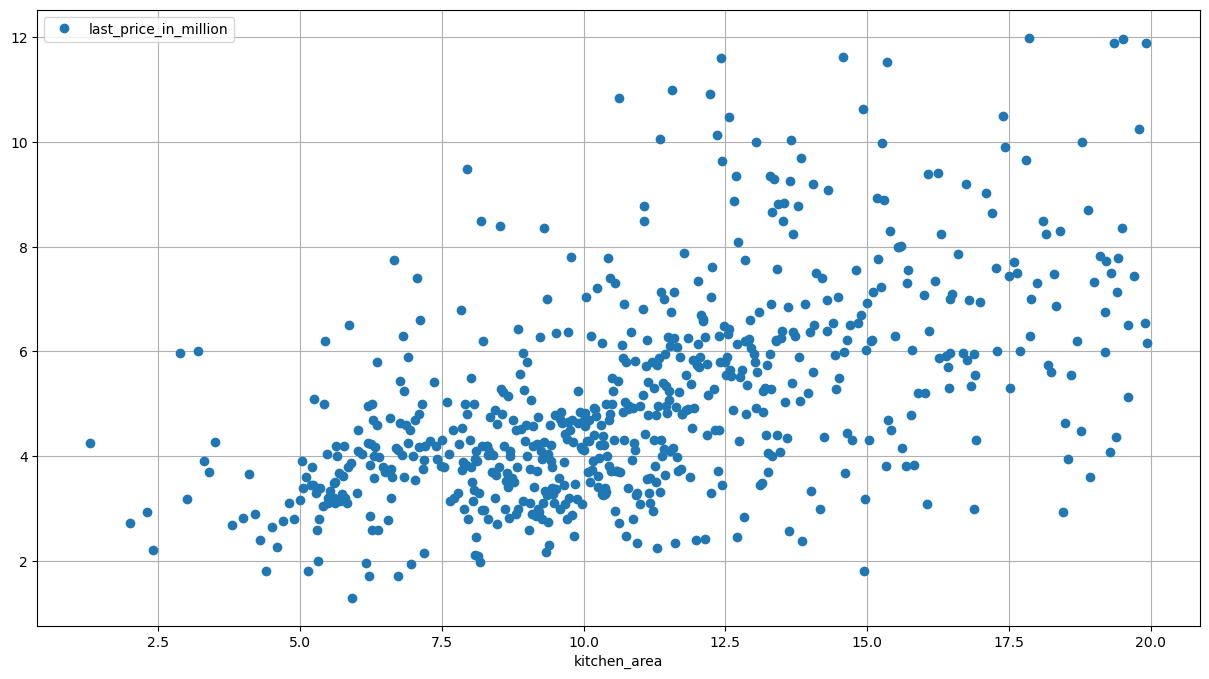

In [166]:
price_per_sqrt = (
    df.query('last_price_in_million < 12 and kitchen_area < 20')
    .pivot_table(index='kitchen_area',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True,figsize=(15, 8))
)
price_per_sqrt

In [167]:
df.query('kitchen_area < 20')['kitchen_area'].corr(df.query('last_price_in_million < 12')['last_price_in_million'])

0.48852767215030857

**Также есть тенденция к росту цены с увеличением площади кухни, но уже значительно меньше. Так как общая площадь и площадь кухни взаимо зависимые показатели, нельзя точно сказать, что площадь кухни сильно влияет на цену. Добавлю, что появилось много значений, где кухня большая, а цена — нет.**

##### Количество комнат.

<AxesSubplot:xlabel='rooms'>

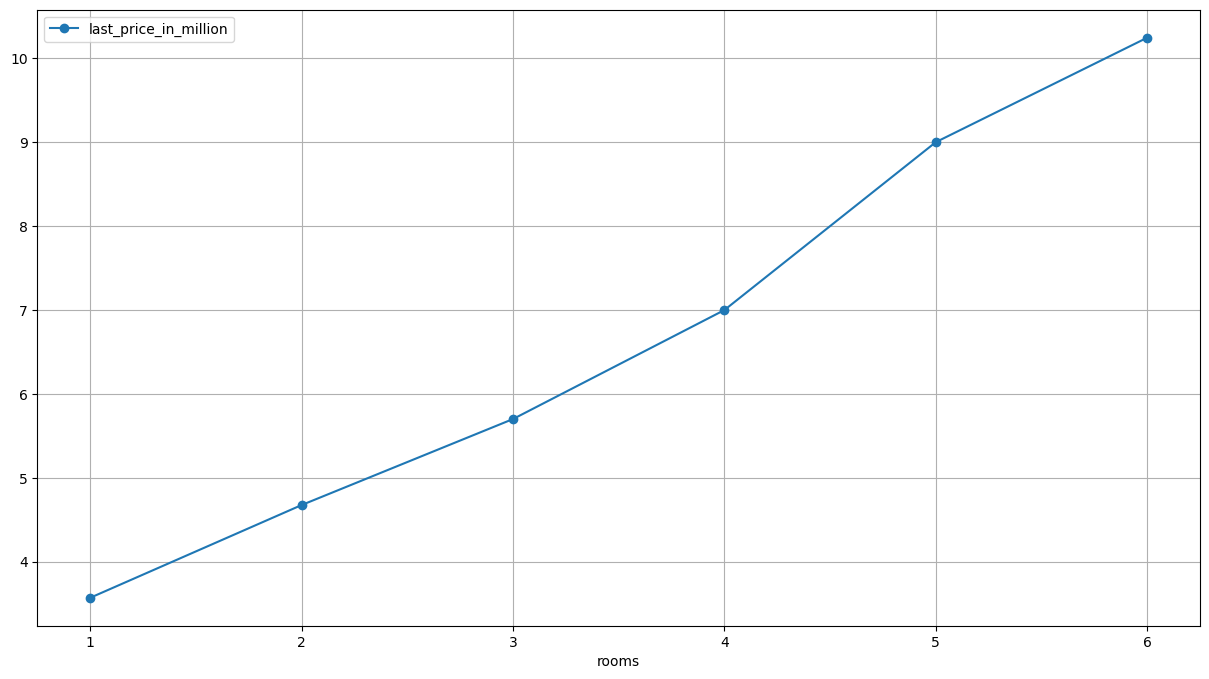

In [168]:
price_per_sqrt = (
    df.query('last_price_in_million < 12 and rooms < 7')
    .pivot_table(index='rooms',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o-', grid=True,figsize=(15, 8))
)
price_per_sqrt

In [169]:
df.query('rooms < 7')['rooms'].corr(df.query('last_price_in_million < 12')['last_price_in_million'])

0.45402689448115446

In [170]:
df.query('rooms < 7')['rooms'].corr(df.query('total_area < 115')['total_area'])

0.7883107389252274

**Можно ли назвать количество комнта полностью самостоятельно величиной, влияющей на цену? Слишком сильная зависимость от общей площади. Но, да, чем больше комнат, тем выше цена.**

##### Этаж квартиры.

<AxesSubplot:xlabel='floor'>

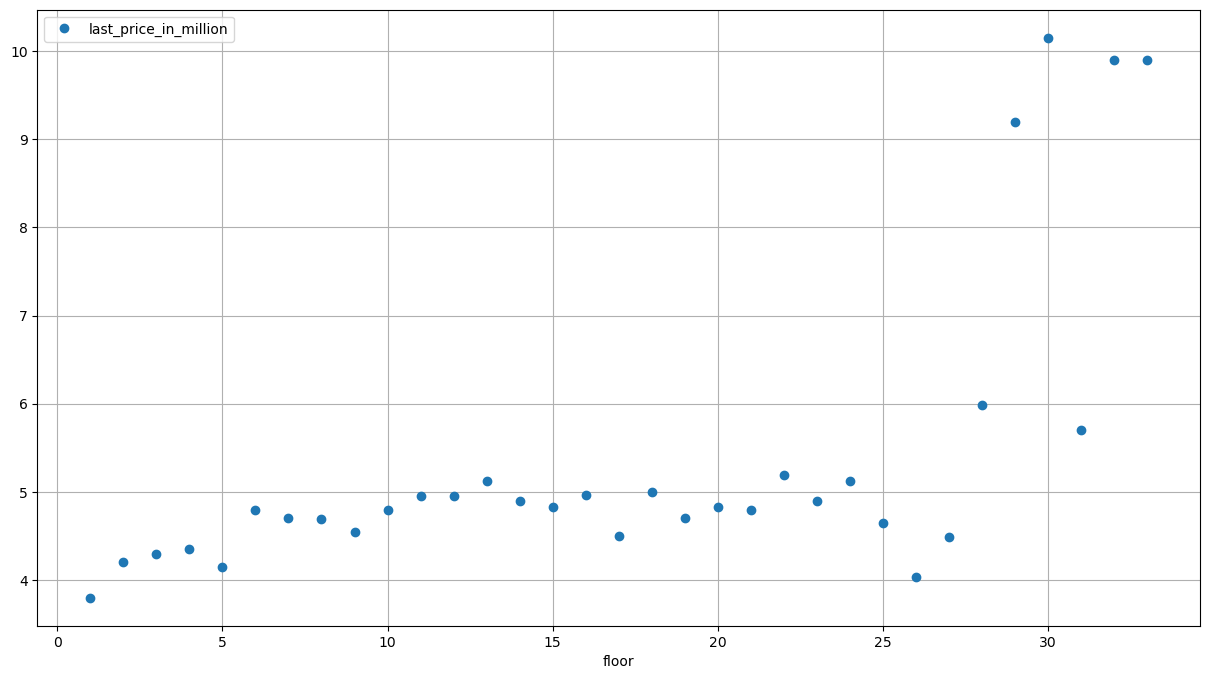

In [178]:
price_per_sqrt = (
    df.query('last_price_in_million < 12')
    .pivot_table(index='floor',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True,figsize=(15, 8))
)
price_per_sqrt

In [185]:
df['floor'].corr(df.query('last_price_in_million < 12')['last_price_in_million'])

0.12670226326916842

**Цены на жилье от 5 и до 27 этажа примерно одинаковые. Цена за жилье на 30 этаже — выброс. Стоимость квартир/домов до 5 этажа может быть связана и с тем, что это старый фонд, и с тем, что в выборку попали деревни. Последний момент стоит проверить.**

<AxesSubplot:xlabel='floor'>

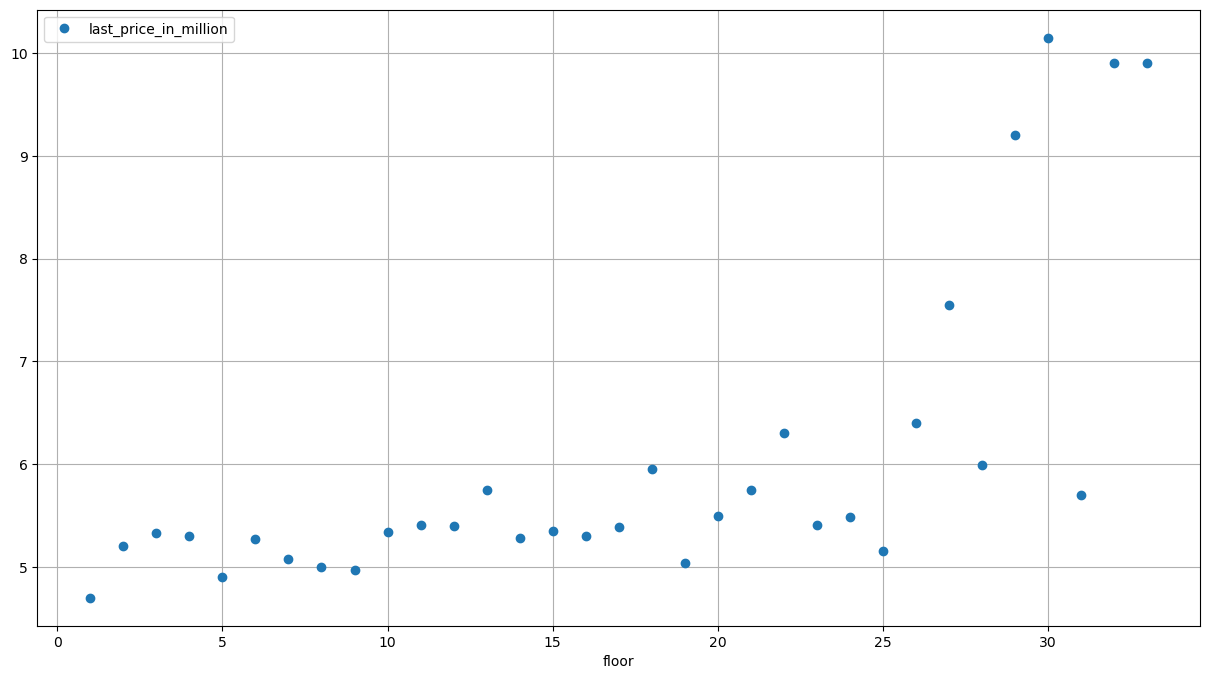

In [187]:
price_per_sqrt = (
    df.query('last_price_in_million < 12 and locality_name == "Санкт-Петербург"')
    .pivot_table(index='floor',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True,figsize=(15, 8))
)
price_per_sqrt

**Нет, догадка не подтвердилась, но тем не менее можно заметить, что в СПб жилье в среднем дороже на 1 млн. рублей.**

##### Дата размещения.

<AxesSubplot:xlabel='first_day_exposition'>

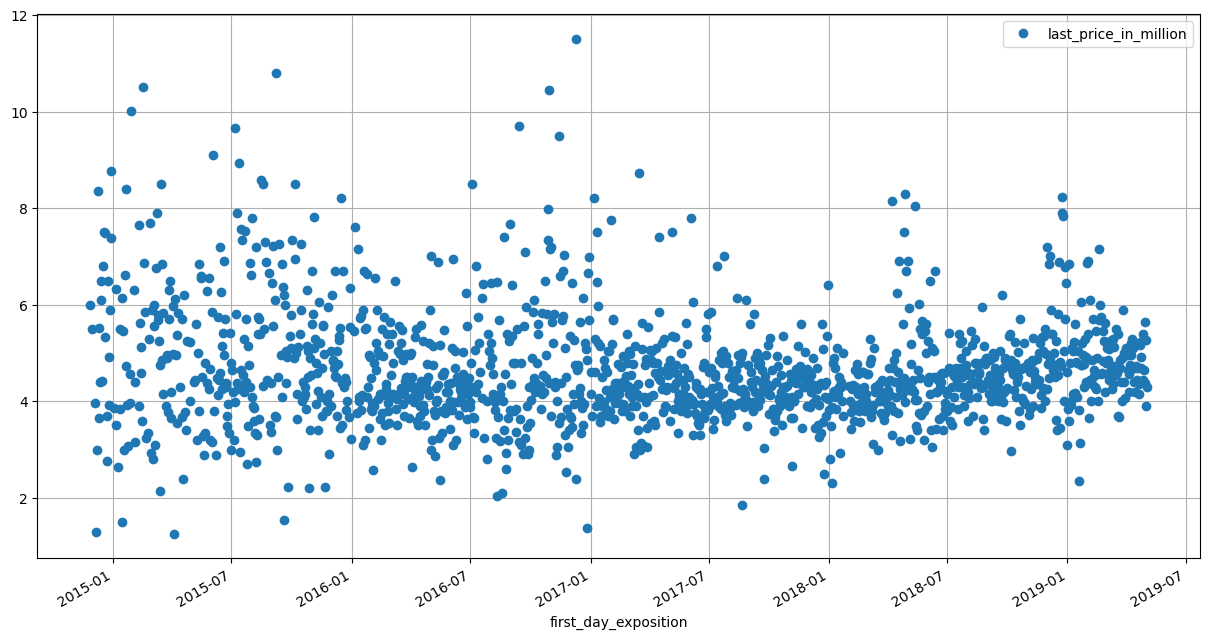

In [188]:
price_per_date = (
    df.query('last_price_in_million < 12')
    .pivot_table(index='first_day_exposition',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True,figsize=(15, 8))
)
price_per_date

**В прошлом цена была более разнообразная, начиная с 2017 года объявления плотно сгруппировались в промежутке стоимость от 2 до 6 млн, разброс стал меньше. Хочется связать это с тем, что низкая цена более привлекательная в наше время.**

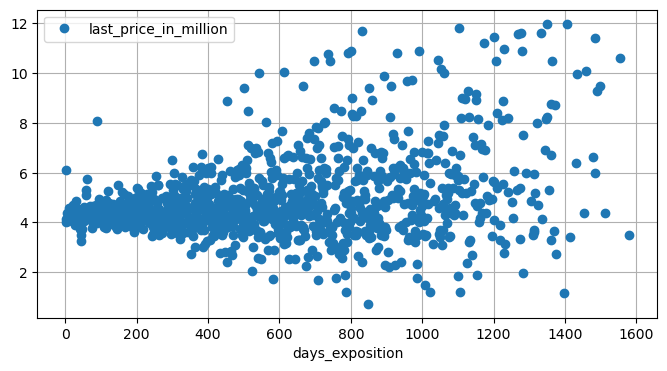

In [189]:
price_per_year = (
    df.query('last_price_in_million < 12')
    .pivot_table(index='days_exposition',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True,figsize=(8, 4))
)

##### Расстояние до центра.

<AxesSubplot:xlabel='cityCenters_nearest'>

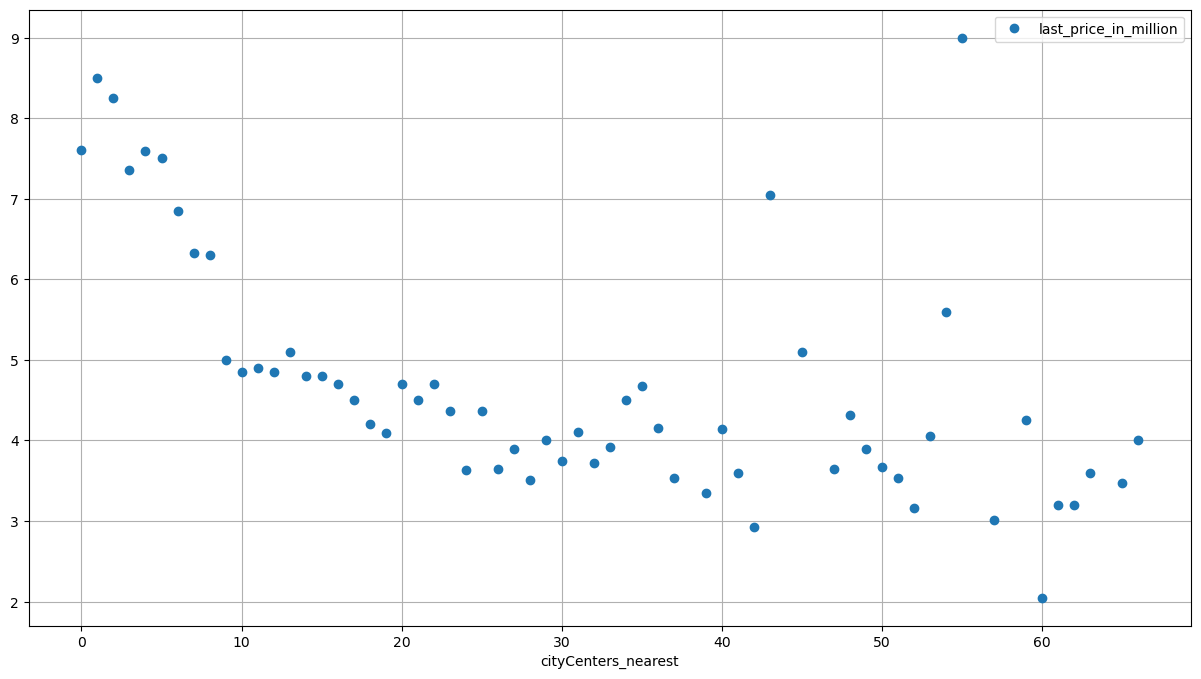

In [190]:
price_per_sqrt = (
    df.query('last_price_in_million < 12')
    .pivot_table(index='cityCenters_nearest',
                   values='last_price_in_million',
                   aggfunc=('median')).sort_values(by='last_price_in_million')
    .plot(style='o', grid=True,figsize=(15, 8))
)
price_per_sqrt

**Ожидаемо — цена растет с приближением к центру.**

##### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [191]:
arr = df['locality_name'].value_counts().head(10)
arr

Санкт-Петербург      15721
Мурино                 590
Кудрово                472
поселок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
поселок Парголово      327
Гатчина                307
Выборг                 237
Name: locality_name, dtype: int64

In [192]:
count_top_price = (
    df.pivot_table(index='locality_name', values='price_per_sqre_meter', aggfunc=['count', 'mean'])
    
)
count_top_price.columns = ['count', 'mean']
count_top_price.sort_values(by='count', ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,15721,114851.715283
Мурино,590,86087.512050
Кудрово,472,95324.930544
поселок Шушары,440,78677.364217
Всеволожск,398,68654.473986
Пушкин,369,103125.819291
Колпино,338,75424.579098
поселок Парголово,327,90175.913458
Гатчина,307,68746.146763


In [193]:
count_top_price['mean'].head(10)

locality_name
Бокситогорск     17551.591819
Волосово         40183.325974
Волхов           35087.679877
Всеволожск       68654.473986
Выборг           58141.909153
Высоцк           35986.304502
Гатчина          68746.146763
Зеленогорск     115122.799198
Ивангород        32591.904362
Каменногорск     27969.167698
Name: mean, dtype: float64

**Из топ 10 городов по популярности самая высокая цена — Санкт-Петербург, самая низкая — Выборг.**

In [194]:
count_top_price.sort_values(by='mean', ascending=False).head(10)

,count,mean
locality_name,,
Зеленогорск,24,115122.799198
Санкт-Петербург,15721,114851.715283
поселок Репино,4,104238.614786
Пушкин,369,103125.819291
Сестрорецк,183,101757.616875
поселок Лисий Нос,3,100660.814239
деревня Мистолово,11,98549.976709
поселок Левашово,1,96997.690531
Кудрово,472,95324.930544


**Самая высокая цена за квадратный метр в Зеленогорске. Во всех поселках и деревнях, которые вошли в топ 10 по цене — продаются коттеджи. У частных домов всегда цена выше, чем у квартиры. Также некоторые характеристики, например, такие как площадь, сильно отличаются от квартир. Все это портит данные. На мой взгляд не корректно сравнивать два разных типа жилья. Я бы рекомендовал добавить еще одну фичу для объявлений — частный дом / квартира.**

In [195]:
count_top_price.sort_values(by='mean', ascending=False).tail(10)

,count,mean
locality_name,,
поселок Житково,2,14956.275202
деревня Ям-Тесово,2,13711.553373
деревня Сижно,1,13709.677419
поселок Тёсово-4,1,12931.034483
деревня Малая Романовка,1,12724.550898
поселок Совхозный,2,12629.129129
деревня Выскатка,2,12335.480902
деревня Вахнова Кара,1,11688.311688
поселок станции Свирь,2,11481.481481


**Самая низкая цена в поселках и деревнях, максимально отдаленных от СПб.**

##### Среднюю цену каждого километра в Санкт-Петербугре

<AxesSubplot:xlabel='cityCenters_nearest'>

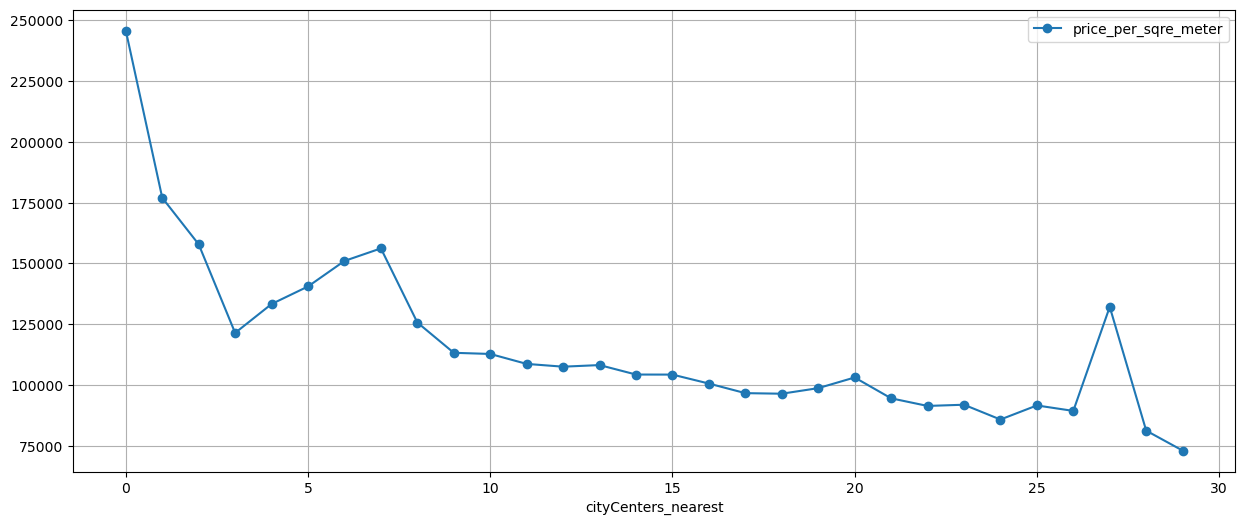

In [196]:
count_top_price_to_centre = (
    df.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest', values='price_per_sqre_meter')
)
count_top_price_to_centre.plot(style='o-', grid=True, figsize=(15, 6))

In [197]:
count_top_price_to_centre.columns = ['count']
count_top_price_to_centre.sort_values('count', ascending=False).head(10)

,count
cityCenters_nearest,
0.0,245833.530289
1.0,177005.407676
2.0,157849.007329
7.0,156176.879664
6.0,151012.193621
5.0,140509.789046
4.0,133282.874761
27.0,132115.709459
8.0,125671.442742


**Цена равномерно снижается в пределах ~3 км от центра, немного увеличивается в промежутке от 3 до 7 км. Далее вплоть до 25 км стоимость значительно не меняется. Можно сказать, что центром считается область с радиусом 3-7 км, все, что дальше — окраины.**

**Если объявление "не в центре", то уже не столь важно, где находится жилье. Кстати, а что насчет метро? На мой взгляд весьма важная фича, влияющая на стоимость. Наличие метро могло бы изменить взгляд на объявления с окраин города.**

**Если говорить о центре, то там каждый метр влияет на стоимость жилья.**

##### Ценообразующие фичи

In [198]:
df[['total_area', 'ceiling_height', 'rooms', 'floor', 'last_price_in_million', 'cityCenters_nearest']].corr()

,total_area,ceiling_height,rooms,floor,last_price_in_million,cityCenters_nearest
total_area,1.000000,0.357467,0.760233,-0.024754,0.653704,-0.231255
ceiling_height,0.357467,1.000000,0.223861,-0.040330,0.268068,-0.270276
rooms,0.760233,0.223861,1.000000,-0.148302,0.365210,-0.186520
floor,-0.024754,-0.040330,-0.148302,1.000000,0.026646,0.008574
last_price_in_million,0.653704,0.268068,0.365210,0.026646,1.000000,-0.207010
cityCenters_nearest,-0.231255,-0.270276,-0.186520,0.008574,-0.207010,1.000000


### Общий вывод

[Вернуться к оглавлению](#Оглавление:)

#### Корреляция

**В ходе исследования я обнаружил несколько важных зависимостей.**

**Сильнее всего на цену жилья влияет общая площадь. Можно отдельно выделить жилую площадь, размер кухни, количество комнат. По отдельности каждый из этих параметров по разному коррелирует с ценой, но все они являются слагаемыми общей площади. Поэтому по ним можно сделать общий вывод — чем больше дом/квартира, тем будет выше стоимость. <span style="color:red">Коэффициент корреляции ~ 0.65</span>.**

**Высота потолков. Тут также, как и с площадью — чем выше, тем лучше. Люди ценят объем. <span style="color:red">Коэффициент корреляции ~ 0.27</span>**

**Третье место по важности я отдаю расстоянию от центра. Этот показатель можно разделить на две категории — центр и не центр. Наибольшее влияние на стоимость оказывает значение до 3 км. <span style="color:red">Коэффициент корреляции ~ -0.2</span>**

**Остальные параметры также влияют на стоимость, но только в совокупности. Можно выделить расстояние до ближайшего парка, водоема, аэропорта, оформление объявления — количество фотографий на сайте.**

![](../../output.png)
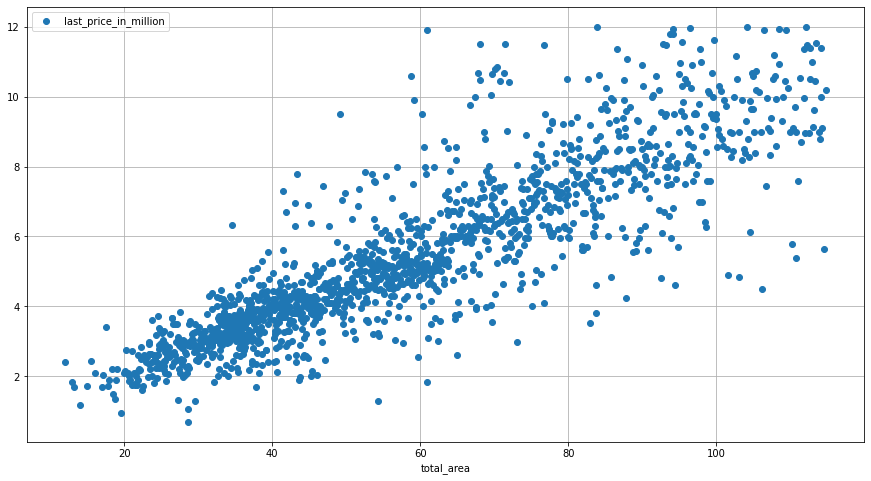

**Зависимость цены от площади**

#### Сколько в среднем висит объявление.

**Большинство объявлений ждут покупателя от 45 до 232 дней. Нередки случаи продажи жилья в срок до 45 дней.**

**Разумеется, на скорость покупки влияет в первую очередь стоимость.**

![](../../output.png)
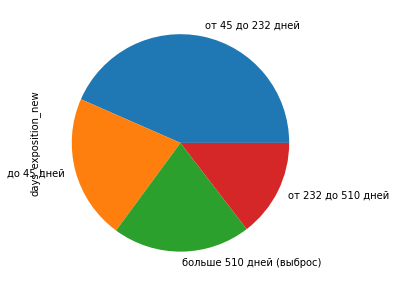

#### Когда чаще всего размещают и покупают жилье.

**На первом графике видна "просадка" по числу объявлений в теплое время года. На втором графике ситуация противоположная — зимой количество покупок сокращается.**

![](../../1.png)
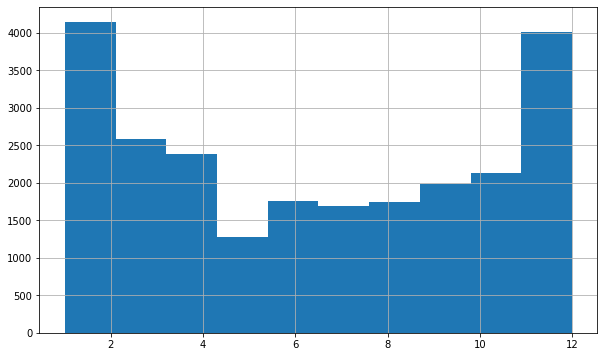

**Количество объявлений по месяцам**

![](../../2.png)
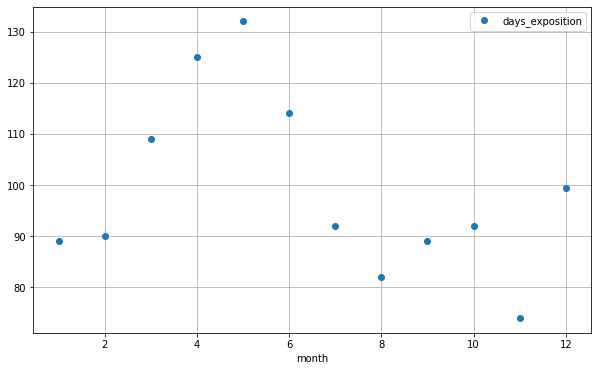

**Количество продаж по месяцам**

**А вот цена растет вместе с количеством объявлений! Зимой и выбор больше, но и цена выше!**

![](../../3.png)
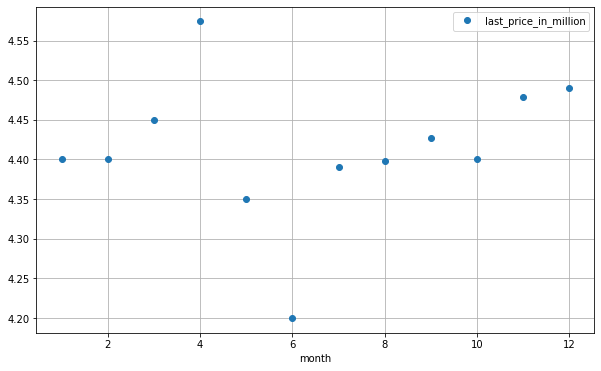

**Я бы задал вопрос менеджменту, что мы можем предложить людям в теплое время года, чтобы они разместили жилье до холодов? Нужно оттянуть часть объявлений с зимы на лето, чтобы выровнять конкуренцию.**

#### Идеальный портрет.

**Что определит цену?**
* Комнат побольше
* Этаж повыше, но не сильно
* Поближе к центру, лучше всего в пределах 3 км
* Цену пониже
* Рядом с полезной инфраструктурой, пруды-парки
* Если цель сэкономить — смотреть объявления с мая по август, в  сентябре начинается рост цен
* Если нужно продать жилье, то зимой цены выше, но и конкуренция больше, это нужно учитывать